## Tutorial : Symbolic Regression from scratch

Let's implement a minimal automated equation discovery algorithm that uses deep reinforcement learning to discover mathematical expressions that fit a given dataset, using only Numpy and PyTorch.

In [52]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Fix seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)


### Token

Let's start by defining a `Token` class to represent mathematical symbols: operators, functions, variables, and constants. Each token will have a symbol, arity (number of arguments it takes), and a function that defines its behavior.

In [53]:
class Token:

    def __init__(self, symbol="+", arity=2, function=None, value=None):
        self.symbol   = symbol
        self.arity    = arity
        self.value    = value
        self.function = function
        # A token is a variable/constant if it takes no arguments
        if arity > 0:
            self.is_function = True
        else:
            self.is_function = False

    def __repr__(self):
        return self.symbol

    def __call__(self, *args):
        if self.is_function:
            return self.function(*args)
        else:
            return self.value


#### Usage example

Your Token class should now be able to represent mathematical symbols:

E.g.:
- x1() should return the value of the variable
- add(a,b) should return a + b

In [54]:
add = Token(symbol="+",   arity=2, function=torch.add,)
sub = Token(symbol="-",   arity=2, function=torch.sub,)
cos = Token(symbol="cos", arity=1, function=torch.cos,)
pi  = Token(symbol="pi",  arity=0, value=3.14)
x1  = Token(symbol="x1",  arity=0, value=torch.linspace(-5, 5, 100))

In [55]:
print(x1)
print(x1())

x1
tensor([-5.0000, -4.8990, -4.7980, -4.6970, -4.5960, -4.4949, -4.3939, -4.2929,
        -4.1919, -4.0909, -3.9899, -3.8889, -3.7879, -3.6869, -3.5859, -3.4848,
        -3.3838, -3.2828, -3.1818, -3.0808, -2.9798, -2.8788, -2.7778, -2.6768,
        -2.5758, -2.4747, -2.3737, -2.2727, -2.1717, -2.0707, -1.9697, -1.8687,
        -1.7677, -1.6667, -1.5657, -1.4646, -1.3636, -1.2626, -1.1616, -1.0606,
        -0.9596, -0.8586, -0.7576, -0.6566, -0.5556, -0.4545, -0.3535, -0.2525,
        -0.1515, -0.0505,  0.0505,  0.1515,  0.2525,  0.3535,  0.4545,  0.5556,
         0.6566,  0.7576,  0.8586,  0.9596,  1.0606,  1.1616,  1.2626,  1.3636,
         1.4646,  1.5657,  1.6667,  1.7677,  1.8687,  1.9697,  2.0707,  2.1717,
         2.2727,  2.3737,  2.4747,  2.5758,  2.6768,  2.7778,  2.8788,  2.9798,
         3.0808,  3.1818,  3.2828,  3.3838,  3.4848,  3.5859,  3.6869,  3.7879,
         3.8889,  3.9899,  4.0909,  4.1919,  4.2929,  4.3939,  4.4949,  4.5960,
         4.6970,  4.7980,  4.8990,  5

Evaluate a functional form using the tokens:

In [56]:
y = cos(sub(pi(), x1()))

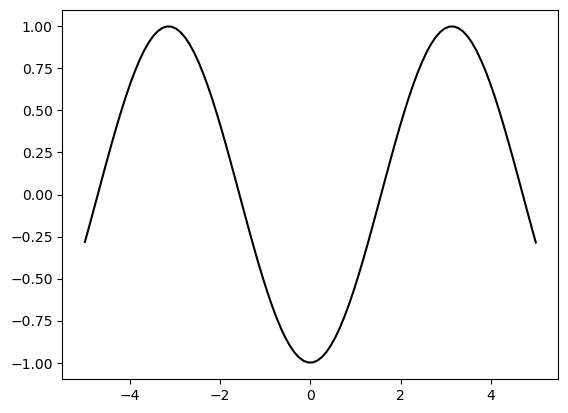

In [57]:
fig, ax = plt.subplots()
ax.plot(x1.value.numpy(), y.numpy(), 'k-')
plt.show()

### Expression

Let's define an `Expression` class that can take a list of tokens in prefix notation and can generate a human-readable formula as well as evaluate the expression.

Prefix notation (also known as Polish notation) is a way of writing mathematical expressions where the operator precedes their operands. For example, the expression `cos(pi - x1)` would be represented in prefix notation as `[cos, -, x1, pi]`.

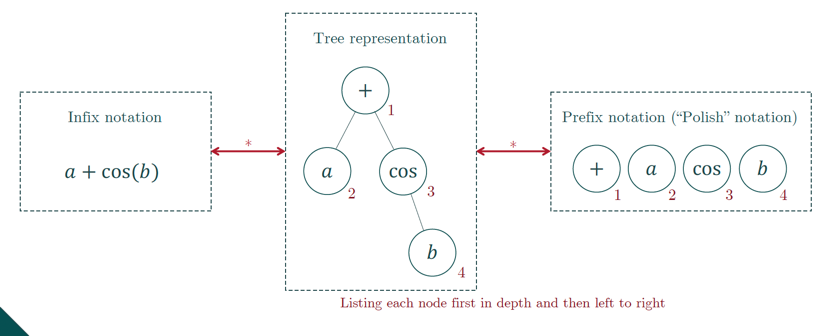

In [58]:
class Expression:

    def __init__(self, tokens):
        """
        Initialize the Expression with a list of tokens in prefix notation.
        Args:
            tokens (list of Token): The tokens representing the expression in prefix notation.
        """
        self.tokens = tokens

    def __repr__(self):
        """Simply showing the list of tokens when the expression is printed."""
        return str(self.tokens)

    def formula(self):
        """Generate a human-readable formula from the tokens in prefix notation."""
        stack = []
        # Going through the tokens in reverse order
        for token in self.tokens[::-1]:
            # If the token is a variable/constant, push it onto the stack
            if token.arity == 0:
                res = token.symbol
                stack.append(res)
            # If the token is a function, pop the required number of arguments from the stack,
            # apply the function, and push the result back onto the stack
            elif token.arity == 1:
                arg = stack.pop()
                res = f"{token.symbol}({arg})"
                stack.append(res)
            # If the token is a binary operator, pop two arguments from the stack,
            # apply the operator, and push the result back onto the stack
            elif token.arity == 2:
                arg1 = stack.pop()
                arg2 = stack.pop()
                res = f"({arg1} {token.symbol} {arg2})"
                stack.append(res)
        return stack[0]

    def evaluate(self):
        """Evaluate the expression represented by the tokens in prefix notation."""
        # Simular to formula, but actually computes the value
        stack = []
        for token in self.tokens[::-1]:
            if token.arity == 0:
                stack.append(token.value)
            elif token.arity == 1:
                arg = stack.pop()
                res = token(arg)
                stack.append(res)
            elif token.arity == 2:
                arg1 = stack.pop()
                arg2 = stack.pop()
                res = token(arg1, arg2)
                stack.append(res)
        return stack[0]


#### Usage example

Represent and evaluate the expression `cos(pi - x1)` using the `Expression` class.

In [59]:
my_formula = Expression(tokens=[cos, sub, x1, pi])
print(my_formula.formula())

cos((x1 - pi))


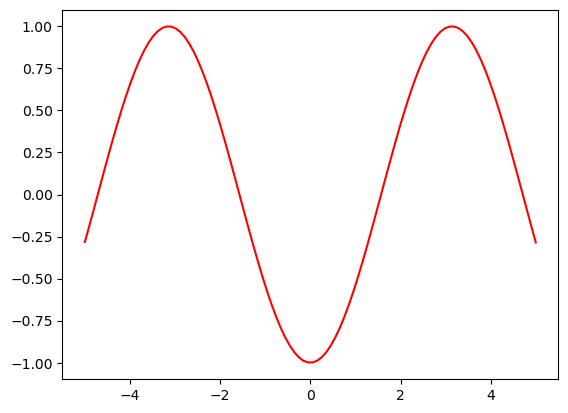

In [60]:
y = my_formula.evaluate()
fig, ax = plt.subplots()
ax.plot(x1.value.numpy(), y.numpy(), 'r-')
plt.show()

### Tree completeness

An expression is complete if it has no missing nodes.
For example, the expression `[+, x1]` is incomplete because the `+` operator requires two arguments, but only one (`x1`) is provided. The expression `[cos, +, x1, pi]` is complete because all operators and functions have the required number of arguments.

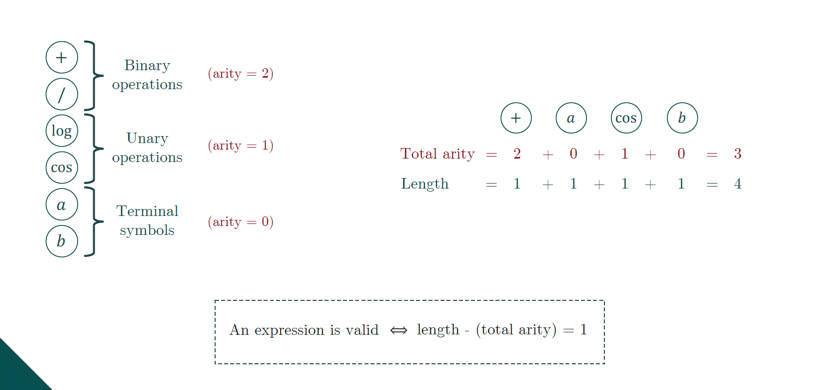
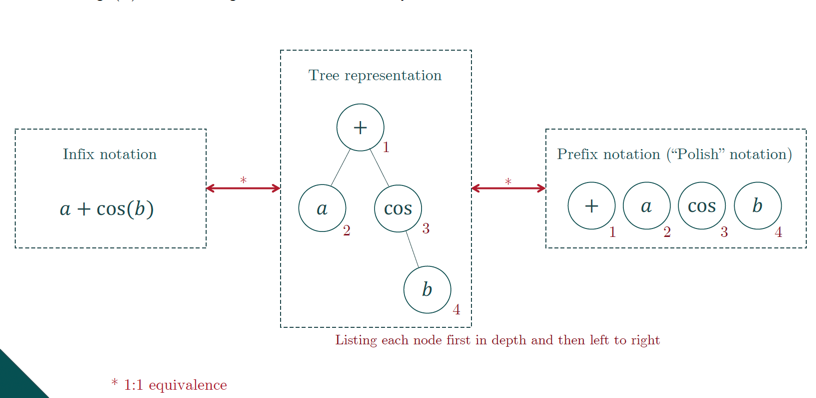
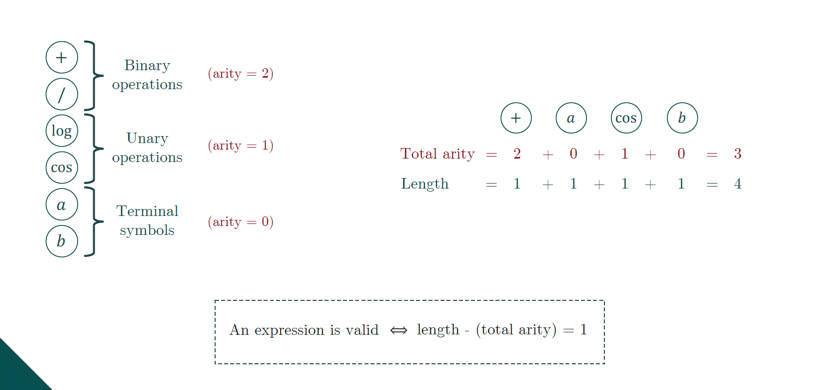
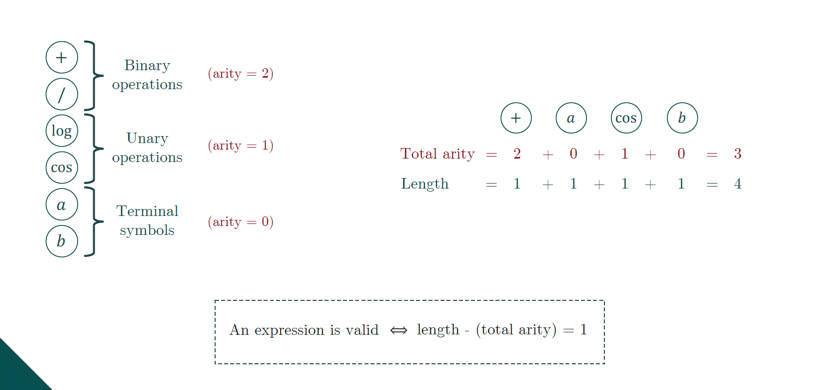

In [61]:
class Expression:

    def __init__(self, tokens):
        """
        Initialize the Expression with a list of tokens in prefix notation.
        Args:
            tokens (list of Token): The tokens representing the expression in prefix notation.
        """
        self.tokens = tokens

    def __repr__(self):
        """Simply showing the list of tokens when the expression is printed."""
        return str(self.tokens)

    def formula(self):
        """Generate a human-readable formula from the tokens in prefix notation."""
        stack = []
        # Going through the tokens in reverse order
        for token in self.tokens[::-1]:
            # If the token is a variable/constant, push it onto the stack
            if token.arity == 0:
                res = token.symbol
                stack.append(res)
            # If the token is a function, pop the required number of arguments from the stack,
            # apply the function, and push the result back onto the stack
            elif token.arity == 1:
                arg = stack.pop()
                res = f"{token.symbol}({arg})"
                stack.append(res)
            # If the token is a binary operator, pop two arguments from the stack,
            # apply the operator, and push the result back onto the stack
            elif token.arity == 2:
                arg1 = stack.pop()
                arg2 = stack.pop()
                res = f"({arg1} {token.symbol} {arg2})"
                stack.append(res)
        return stack[0]

    def evaluate(self):
        """Evaluate the expression represented by the tokens in prefix notation."""
        # Simular to formula, but actually computes the value
        stack = []
        for token in self.tokens[::-1]:
            if token.arity == 0:
                stack.append(token.value)
            elif token.arity == 1:
                arg = stack.pop()
                res = token(arg)
                stack.append(res)
            elif token.arity == 2:
                arg1 = stack.pop()
                arg2 = stack.pop()
                res = token(arg1, arg2)
                stack.append(res)
        return stack[0]

    def length(self):
        """Return the number of tokens in the expression."""
        return len(self.tokens)

    def n_missing_nodes(self):
        """Return the number of missing nodes to complete the expression."""
        total_arities = 0
        for token in self.tokens:
            total_arities += token.arity
        res = total_arities - (self.length() - 1)
        return res

    def is_complete(self):
        """Check if the expression is complete (no missing nodes)."""
        return self.n_missing_nodes() == 0

    def append(self, token):
        """
        Append a token to the expression if it is not complete.
        Parameters
        ----------
        token : Token
            Token to append.
        """
        # Only append the token if the expression is not complete
        # Let's ignore the token otherwise
        if not self.is_complete():
            self.tokens.append(token)

#### Usage example

In [62]:
# Let's pretend the model is generating tokens:
tokens_generated = [add, cos, sub, x1, pi, cos, x1]

for step in range (len(tokens_generated)):
    expr = Expression(tokens=tokens_generated[:step+1])
    print(f"-- Step : {step} --")
    print(f" Tokens in the expression: {expr}")
    print(f" Nb of missing nodes : {expr.n_missing_nodes()}")
    print(f" Complete: {expr.is_complete()}")
    if expr.is_complete():
        print(f" Formula: {expr.formula()}")

-- Step : 0 --
 Tokens in the expression: [+]
 Nb of missing nodes : 2
 Complete: False
-- Step : 1 --
 Tokens in the expression: [+, cos]
 Nb of missing nodes : 2
 Complete: False
-- Step : 2 --
 Tokens in the expression: [+, cos, -]
 Nb of missing nodes : 3
 Complete: False
-- Step : 3 --
 Tokens in the expression: [+, cos, -, x1]
 Nb of missing nodes : 2
 Complete: False
-- Step : 4 --
 Tokens in the expression: [+, cos, -, x1, pi]
 Nb of missing nodes : 1
 Complete: False
-- Step : 5 --
 Tokens in the expression: [+, cos, -, x1, pi, cos]
 Nb of missing nodes : 1
 Complete: False
-- Step : 6 --
 Tokens in the expression: [+, cos, -, x1, pi, cos, x1]
 Nb of missing nodes : 0
 Complete: True
 Formula: (cos((x1 - pi)) + cos(x1))


### Length constraint

Hint 1 : An expression is complete when it has no missing nodes.
Hint 2 : You can use expression.length(), expression.n_missing_nodes() and token.arity to check if the
prospective length is <= max_length.

In [63]:
def hard_length_constraint(token, expression, max_length):
    """
    Can token be added to the expression without exceeding max_length?
    If the expression is complete, adding a new token will always exceed max_length so let's return True so the model
    can be sampled properly even though we will ignore the sampled token.

    Parameters
    ----------
    token : Token
        Token to add.
    expression : Expression
        Expression being built.
    max_length : int
        Maximum allowed length of the expression.
    Returns
    -------
    is_allowed : bool
        True if token can be added, False otherwise.
    """
    # If we add the token, the total length of the expression at the end of the generation process will be at least:
    prospective_length = expression.length() + expression.n_missing_nodes() + token.arity
    # Because, we sum expression.length() with:
    # expression.n_missing_nodes() : the number of missing nodes (which will have to be filled) and,
    # token.arity : the arity of the new token (which indicates how many new missing nodes ie. arguments it will create).

    if expression.is_complete():
        # If the expression is already complete, adding a new token will always exceed max_length
        return True
    else:
        return prospective_length <= max_length


#### Usage example

In [64]:

# Let's pretend the model is generating tokens:
tokens_generated = [add, cos, sub, x1, pi, cos, x1]

# Let's set our library of available tokens to:
library = np.array([add, sub, cos, pi, x1])

# Let's set a maximum length for the expression:
max_length = 7

for step in range (len(tokens_generated)):
    expr = Expression(tokens=tokens_generated[:step+1])
    # Tokens that are allowed to be added to expr without exceeding max_length
    allowed_tokens = [t for t in library if hard_length_constraint(t, expr, max_length)]
    print(f"-- Step : {step} --")
    print(f" Tokens in the expression: {expr}")
    print(f" Nb of missing nodes : {expr.n_missing_nodes()}")
    print(f" Length : {expr.length()}")
    print(f" Complete : {expr.is_complete()}")
    if expr.is_complete():
        print(f" Formula : {expr.formula()}")
    print(f" Tokens that can be safely added : {allowed_tokens}")

-- Step : 0 --
 Tokens in the expression: [+]
 Nb of missing nodes : 2
 Length : 1
 Complete : False
 Tokens that can be safely added : [+, -, cos, pi, x1]
-- Step : 1 --
 Tokens in the expression: [+, cos]
 Nb of missing nodes : 2
 Length : 2
 Complete : False
 Tokens that can be safely added : [+, -, cos, pi, x1]
-- Step : 2 --
 Tokens in the expression: [+, cos, -]
 Nb of missing nodes : 3
 Length : 3
 Complete : False
 Tokens that can be safely added : [cos, pi, x1]
-- Step : 3 --
 Tokens in the expression: [+, cos, -, x1]
 Nb of missing nodes : 2
 Length : 4
 Complete : False
 Tokens that can be safely added : [cos, pi, x1]
-- Step : 4 --
 Tokens in the expression: [+, cos, -, x1, pi]
 Nb of missing nodes : 1
 Length : 5
 Complete : False
 Tokens that can be safely added : [cos, pi, x1]
-- Step : 5 --
 Tokens in the expression: [+, cos, -, x1, pi, cos]
 Nb of missing nodes : 1
 Length : 6
 Complete : False
 Tokens that can be safely added : [pi, x1]
-- Step : 6 --
 Tokens in the e

### Function protections

Here are some protected versions of usual functions to avoid numerical issues during evaluation e.g. division by zero, overflow, etc.

In [65]:
EPSILON = 0.001
EXP_THRESHOLD = 80.
INF = 1e6

def protected_div(x1, x2):
    #with np.errstate(divide='ignore', invalid='ignore', over='ignore'):
    return torch.where(torch.abs(x2) > EPSILON, torch.divide(x1, x2), 1.)

exp_plateau = np.exp(EXP_THRESHOLD)
def protected_exp(x1):
    #with np.errstate(over='ignore'):
    return torch.where(x1 <= EXP_THRESHOLD, torch.exp(x1), exp_plateau)

log_plateau = np.log(np.abs(EPSILON))
def protected_log(x1):
    #with np.errstate(divide='ignore', invalid='ignore'):
    return torch.where(torch.abs(x1) >= EPSILON, torch.log(torch.abs(x1)), log_plateau)

protected_logabs = protected_log

def protected_sqrt(x1):
    return torch.sqrt(torch.abs(x1))

def protected_cbrt(x1):
    return torch.pow(torch.abs(x1), 1./3)

def protected_inv(x1):
    # with np.errstate(divide='ignore', invalid='ignore'):
    return torch.where(torch.abs(x1) > EPSILON, 1. / x1, 0.)

expneg_plateau = np.exp(--EXP_THRESHOLD)
def protected_expneg(x1):
    # with np.errstate(over='ignore'):
    return torch.where(x1 >= -EXP_THRESHOLD, torch.exp(-x1), expneg_plateau)

n2_plateau = np.square(INF)
def protected_n2(x1):
    # with np.errstate(over='ignore'):
    return torch.where(torch.abs(x1) <= INF, torch.square(x1), n2_plateau)

n3_plateau = np.power(INF, 3)
def protected_n3(x1):
    # with np.errstate(over='ignore'):
    return torch.where(torch.abs(x1) <= INF, torch.pow(x1, 3), torch.sign(x1)*n3_plateau)

n4_plateau = np.power(INF, 4)
def protected_n4(x1):
    # with np.errstate(over='ignore'):
    return torch.where(torch.abs(x1) <= INF, torch.pow(x1, 4), n4_plateau)

def protected_arcsin (x1):
    return torch.where(torch.abs(x1) < (1.-EPSILON), torch.arcsin(x1), torch.sign(x1)*INF)

def protected_arccos (x1):
    return torch.where(torch.abs(x1) < (1.-EPSILON), torch.arccos(x1), torch.sign(x1)*INF)

def protected_torch_pow(x0, x1):
    if not torch.is_tensor(x0):
       x0 = torch.ones_like(x1)*x0
    y = torch.pow(x0, x1)
    y = torch.where(y > INF, INF, y)
    return y


### Random expression generation

Let's generate a batch of random expressions by sampling tokens from a random distribution over the library, while respecting the length constraint.

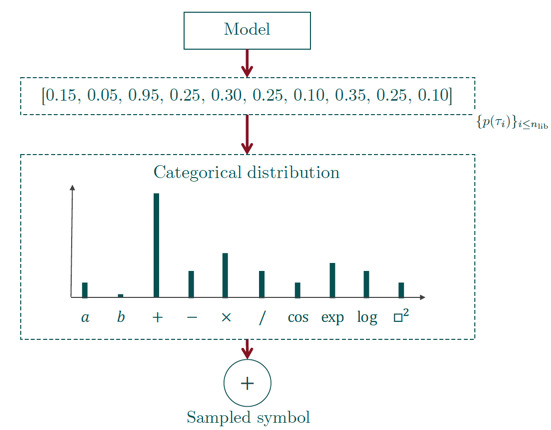

In [66]:
batch_size = 200
max_length = 10


#### Library

In [67]:
add   = Token(symbol="+",   arity=2, function=torch.add,)
sub   = Token(symbol="-",   arity=2, function=torch.sub,)
mul   = Token(symbol="*",   arity=2, function=torch.mul,)
div   = Token(symbol="/",   arity=2, function=protected_div,)
inv   = Token(symbol="inv", arity=1, function=protected_inv,)
exp   = Token(symbol="exp", arity=1, function=protected_exp,)
log   = Token(symbol="log", arity=1, function=protected_log,)
n2    = Token(symbol="n2",  arity=1, function=protected_n2,)
sqrt  = Token(symbol="sqrt",arity=1, function=protected_sqrt,)
cos   = Token(symbol="cos", arity=1, function=torch.cos,)

pi    = Token(symbol="pi",  arity=0, value=torch.tensor(np.pi))
x1    = Token(symbol="x1",  arity=0, value=torch.tensor(np.random.uniform(low=-5, high=5, size=500)))
x2    = Token(symbol="x2",  arity=0, value=torch.tensor(np.random.uniform(low=-5, high=5, size=500)))

library = [add, sub, mul, div, inv, exp, log, n2, sqrt, cos, pi, x1, x2]

# Number of possible tokens to choose from
n_choices = len(library)

#### Generation

In [68]:
# Initialize a batch of empty expressions
expressions = [Expression(tokens=[]) for _ in range(batch_size)]


In [69]:

for i in range(max_length):
    next_tokens_probs = np.random.random((batch_size, n_choices,))                                   # (batch_size, n_choices)

    # Mask out choosable tokens that would exceed max_length if added to the expression
    for j, expr in enumerate(expressions):
        allowed_tokens = np.array([hard_length_constraint(t, expr, max_length) for t in library])     # (n_choices,)
        next_tokens_probs[j, allowed_tokens == False] = 0

    # Normalizing probabilities
    next_tokens_probs = next_tokens_probs / next_tokens_probs.sum(axis=1, keepdims=True)              # (batch_size, n_choices)

    # Sampling indices of the next tokens to add
    next_tokens_indices = [np.random.choice(n_choices, p=next_tokens_probs[j]) for j in range(batch_size)] # (batch_size,)
    next_tokens = [library[idx] for idx in next_tokens_indices]

    # Adding the sampled tokens to the expressions
    for j in range(batch_size):
        expressions[j].append(next_tokens[j])

In [70]:
# Printing the generated expressions:
for expr in expressions:
    print(expr.formula())

((exp(log(log(x1))) * x1) / (pi / pi))
x2
sqrt(log(exp((n2(exp(log(x1))) / inv(x1)))))
cos(inv(n2(exp(x1))))
exp((x1 + (log((cos(x2) - x1)) - x2)))
log((pi / inv((x1 + x1))))
pi
n2(sqrt((pi * (cos(x1) / (x2 + x1)))))
n2(cos((log(exp((n2(pi) / pi))) + pi)))
n2((exp(x1) * pi))
sqrt((n2(exp(x1)) * (x2 + sqrt(x2))))
(sqrt((x1 * n2(log(log(x1))))) + cos(x1))
inv(n2((x2 / cos(((x2 - x2) / pi)))))
(log(log(log(((x2 / pi) * pi)))) * x1)
inv((log(((exp(pi) + x2) + x1)) + x1))
((exp(x1) * (cos(pi) - x1)) * cos(x1))
log(((x2 + (n2(exp(x2)) - x1)) + pi))
(sqrt(cos(x1)) + inv((x1 - (pi * pi))))
x2
log(x2)
((((x1 - x1) * sqrt(x1)) - x1) - pi)
n2(pi)
exp(x1)
(x2 - pi)
sqrt(sqrt(x1))
(((x1 + log(n2(x1))) / pi) - x1)
((exp(((x1 + x2) + x2)) / x2) * x2)
(sqrt(pi) - ((pi / sqrt(log(x1))) / x1))
n2(pi)
sqrt(n2(n2(pi)))
((n2(pi) / ((pi / pi) + x2)) + pi)
(log((pi + ((x1 / x2) + x1))) - x1)
x1
(sqrt((pi * ((x1 + x2) + x2))) - pi)
sqrt(pi)
(cos(sqrt(pi)) / (x1 / (n2(x2) - x1)))
exp(log(sqrt(inv(x2))))
x1
log

### Symbolic Regression

#### Target data

Let's create a target dataset to fit.

In [71]:
y_target = torch.cos(x1.value) + torch.sin(x2.value)

#### LSTM model

In [72]:

class LSTMTokenModel(nn.Module):
    def __init__(self, n_choices, hidden_size=64, num_layers=2):
        super().__init__()
        self.n_choices = n_choices
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=n_choices,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.output_layer = nn.Linear(hidden_size, n_choices)

    def forward(self, x, hidden=None):
        """
        x: (batch, seq_len, n_choices)  # one-hot encoded sequence
        hidden: (h_0, c_0), optional

        returns:
            logits: (batch, seq_len, n_choices)
            new_hidden: tuple of (h_n, c_n)
        """
        out, hidden = self.lstm(x, hidden)
        logits = self.output_layer(out)
        return logits, hidden

    def next_token_probs(self, prev_seq, hidden=None):
        """
        prev_seq: (batch, seq_len, n_choices)
        returns:
            probs: (batch, n_choices)
            new_hidden
        """
        logits, hidden = self.forward(prev_seq, hidden)
        last_logits = logits[:, -1, :]
        probs = F.softmax(last_logits, dim=-1)
        return probs, hidden

#### Generating expressions with a recurrent model

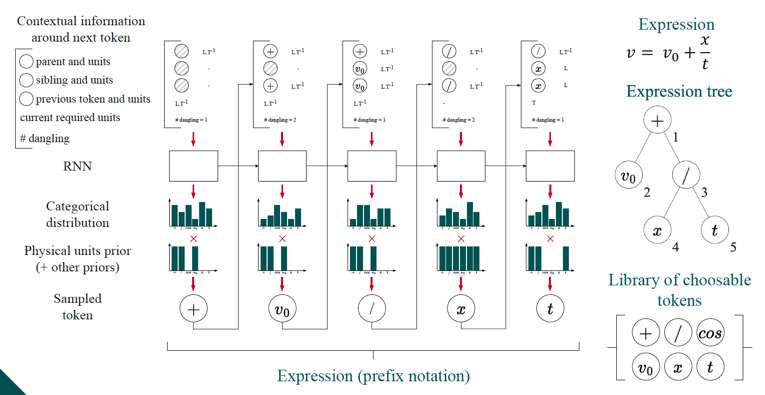

Let's initialize the model

In [73]:
model = LSTMTokenModel(n_choices=n_choices)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {count_parameters(model):,}")

optimizer = torch.optim.Adam(model.parameters(), lr=0.0025,) #0.001, #0.0050, #0.0005, #1,  #lr=0.0025


Number of trainable parameters: 54,349


In [74]:
batch_size = 100
epochs = 100

In [75]:
reward_history_max  = []
reward_history_mean = []

In [76]:
# Iterating through epochs
for epoch in range(epochs):

    optimizer.zero_grad()

    seq_token_probs = [] # Keeping track of the token probabilities given by the model at each step
    seq_token_idx   = [] # Keeping track of the actually sampled tokens idx at each step

    # Initialize a batch of empty expressions for this epoch
    expressions = [Expression(tokens=[]) for _ in range(batch_size)]

    # Iterating through the sequence length
    for i in range(max_length):

        # --------- GENERATION PHASE ---------

        # If this is the first iteration, there is no previous sequence nor hidden state
        if i == 0:
            hidden   = None
            prev_seq = torch.zeros((batch_size, 1, n_choices))

        # Getting the probabilities of the next token to add to each expression in the batch
        next_tokens_probs, hidden = model.next_token_probs(prev_seq,hidden) # (batch_size, n_choices), ...

        # Keeping track of the token probabilities given by the model at each step
        seq_token_probs.append(next_tokens_probs)

        # Non-differentiable sampling step:
        next_tokens_probs_np = next_tokens_probs.detach().numpy()  # (batch_size, n_choices)

        # Mask out choosable tokens that would exceed max_length if added to the expression
        for j, expr in enumerate(expressions):
            allowed_tokens = np.array([hard_length_constraint(t, expr, max_length) for t in library])     # (n_choices,)
            next_tokens_probs_np[j, allowed_tokens == False] = 0
        next_tokens_probs_np = next_tokens_probs_np / next_tokens_probs_np.sum(axis=1, keepdims=True)  # (batch_size, n_choices)
        next_tokens_indices = [np.random.choice(n_choices, p=next_tokens_probs_np[j]) for j in range(batch_size)] # (batch_size,)

        # Keeping track of the actually sampled tokens idx at each step
        seq_token_idx.append(next_tokens_indices)

        # Adding the sampled tokens to the expressions
        next_tokens = [library[idx] for idx in next_tokens_indices]
        for j in range(batch_size):
            expressions[j].append(next_tokens[j])

        # Preparing the input for the next iteration
        prev_seq = torch.zeros((batch_size, 1, n_choices))
        for j in range(batch_size):
            prev_seq[j, 0, next_tokens_indices[j]] = 1

    # --------- EVALUATION PHASE ---------
    # Evaluating fit quality of the generated expressions
    # Using a reward function that is based on the Normalized Root Mean Square Error (NRMSE)
    rewards = []
    for expr in expressions:
        y_pred = expr.evaluate()
        NRMSE = torch.sqrt(torch.mean((y_pred - y_target)**2)) / y_target.std()
        r = 1/(1+NRMSE)
        rewards.append(r.item()) # reward does not need to be differentiable
    rewards = np.array(rewards)                                # (batch_size,)
    # Computing baseline as the mean reward in the batch
    baseline = rewards.mean()

    # Histogram of rewards in the batch
    # fig, ax = plt.subplots()
    # ax.hist(rewards, bins=20)
    # plt.show()

    print("-- Epoch ", epoch, "--")
    print("best reward in batch: ", rewards.max())
    reward_history_max.append(rewards.max())
    print("mean reward in batch: ", rewards.mean())
    reward_history_mean.append(rewards.mean())

    # --------- LEARNING PHASE ---------

    # We can use the risk-seeking strategy where we only learn from the best samples in the batch e.g. top 5% and the associated quantile as baseline

    # # 5% quantile in the rewards
    # r_lim = np.quantile(rewards, 0.05)
    # # Samples better than r_lim are trained on
    # keep = rewards >= r_lim
    # baseline = r_lim

    # Mask length of shape (batch_size, max_length,) : 1 where there is a token, 0 where there is no token in expressions
    mask_length = np.tile(np.arange(0, max_length), (batch_size, 1)  # (batch_size, max_length,)
                          ).astype(int) < np.tile([expr.length() for expr in expressions], (max_length, 1)).transpose()                              # (batch_size, max_length,)
    mask_length = torch.from_numpy(mask_length).float()


    # Probs given by the model at each step
    seq_token_probs = torch.stack(seq_token_probs, dim=1)         # (batch_size, max_length, n_choices)
    # Actually sampled tokens
    seq_token_idx   = torch.tensor(seq_token_idx).transpose(0,1)  # (batch_size, max_length)
    # Actually sampled tokens in one-hot
    seq_token_onehot = F.one_hot(seq_token_idx, num_classes=n_choices).float() # (batch_size, max_length, n_choices)

    # Sum over n_choices dim (cross-entropy)
    neglogp_per_step = F.cross_entropy(seq_token_probs.permute(0,2,1), seq_token_idx, reduction='none') # (batch_size, max_length)
    # Sum over sequence dim
    neglogp = torch.sum(neglogp_per_step * mask_length, dim=1)  # (batch_size,)

    loss_val = ((torch.tensor(rewards)-baseline)*neglogp)

    # Only training on samples better than r_lim
    # loss_val = loss_val[keep]

    loss_val = loss_val.mean()
    loss_val.backward()
    optimizer.step()

-- Epoch  0 --
best reward in batch:  0.5752754505891342
mean reward in batch:  0.20246768002799612
-- Epoch  1 --
best reward in batch:  0.5752754505891342
mean reward in batch:  0.19393688454349367
-- Epoch  2 --
best reward in batch:  0.4942251757256643
mean reward in batch:  0.2152822846718193
-- Epoch  3 --
best reward in batch:  0.5000584364104459
mean reward in batch:  0.1974045633635924
-- Epoch  4 --
best reward in batch:  0.517701443547314
mean reward in batch:  0.22016039331675852
-- Epoch  5 --
best reward in batch:  0.5752754505891342
mean reward in batch:  0.2179488562793481
-- Epoch  6 --
best reward in batch:  0.5330238926920772
mean reward in batch:  0.22827428369038988
-- Epoch  7 --
best reward in batch:  0.5752754505891342
mean reward in batch:  0.22630166623254128
-- Epoch  8 --
best reward in batch:  0.5752754505891342
mean reward in batch:  0.2087767472470177
-- Epoch  9 --
best reward in batch:  0.5752754505891342
mean reward in batch:  0.21567827851486748
-- Ep

#### Results

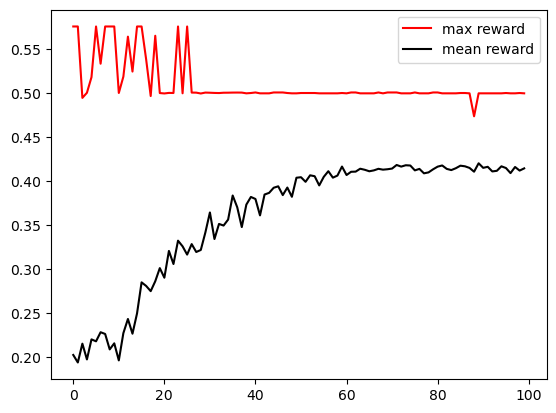

In [77]:
fig, ax = plt.subplots()
ax.plot(reward_history_max,  'r-', label='max reward' )
ax.plot(reward_history_mean, 'k-', label='mean reward')
ax.legend()
plt.show()